In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception = (LoadError("/Users/boothh/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveEnzymeExt.jl", 1, ArgumentError("Package LinearSolve does not have Enzyme in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added Enzyme as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011f04a7dc, Ptr{Nothing} @0x000000011f04aa26, Ptr{Nothing} @0x000000010bd096bd, Ptr{Nothing} @0x000000010bd40a6d, Ptr{Nothing} @0x000000010bd3f84f, Ptr{Nothing} @0x000000010bd40039, Ptr{Nothing} @0x000000010bd3fcad, Ptr{Nothing} @0x000000010bd40ef5, Ptr{Nothing} @0x00000001285c8c41, Ptr{Nothing} @0x000000010b

In [3]:
include(srcdirx("Plotting&Utility.jl"))
include(srcdirx("FittingFunctions.jl"))
# include(srcdirx("old/FittingFunctions_old_cmax.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_DiffusionDominated_Zena_Set2"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

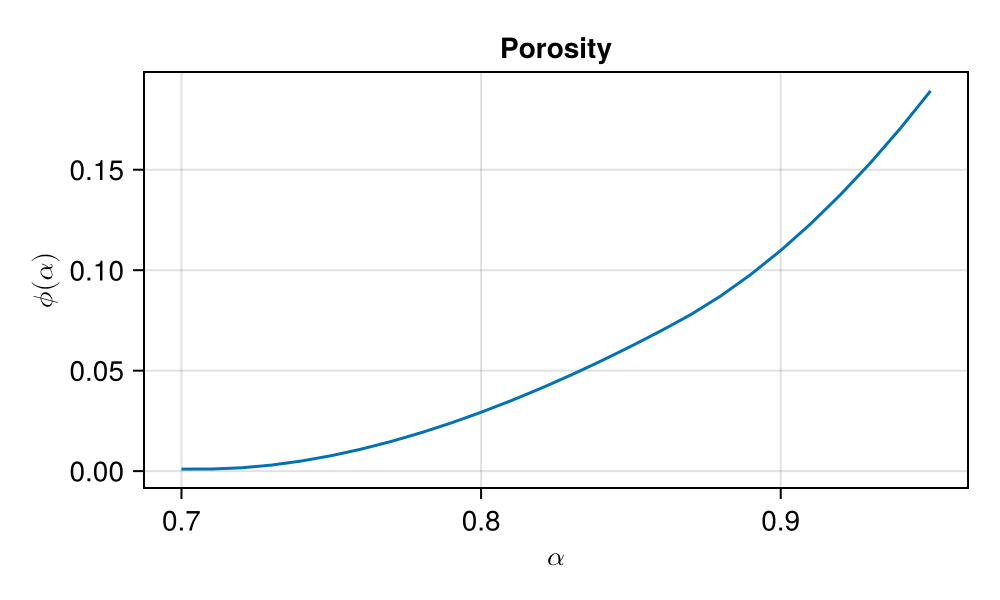

In [4]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [5]:
alpha_data_times_norm

6-element Vector{Float64}:
 0.0
 0.3
 0.6
 0.9
 1.2
 1.5

In [6]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]
# pv_orig = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_OptParmas.jld2")["OptimalParam"][3]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [7]:
# orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data,0.2)

In [8]:
# function get_lambda_half_v1(sol,t_range)
#     c0_t = [maximum(sol(t)[:,1]) for t in t_range] .- 1e-10

#     λhalf_id = [findall(sol(t)[:,1] .- 1e-10 .> 0.5*c0) for (t,c0) in zip(t_range,c0_t)]
#     λhalf_x = [length(id_list) != 0 ? tissue[maximum(id_list)] : 0. for id_list in λhalf_id];

#     λhalf_x, t_range[maximum(findall(x->x==maximum(λhalf_x),λhalf_x))]
# end

In [9]:
# fig = Figure(size = (500,300))

# ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
# ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

# hidexdecorations!(ax_N)

# sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

# N_samp = 10000

# λ_trange = LinRange(0.,sol.t[end],N_samp)

# sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u),saveat = λ_trange);

# N0t = [sol(t)[1,1] for t in λ_trange]

# λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

# c_max = maximum(sol(λhalf_max_t)[:,1])

# lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

# lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

# vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

# save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT.pdf"),fig)

# fig

In [10]:
# fig = Figure(size = (500,300))

# ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
# ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

# hidexdecorations!(ax_N)

# sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

# N_samp = 10000

# λ_trange = LinRange(0.,sol.t[end],N_samp)

# sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u),saveat = λ_trange);

# N0t = [sol(t)[1,1] for t in λ_trange]

# λhalf,λhalf_max_t = get_lambda_half_v1(sol,λ_trange)

# c_max = maximum(sol(λhalf_max_t)[:,1])

# lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

# lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

# vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

# save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT_v1.pdf"),fig)

# fig

In [11]:
# fig = Figure(size = (1200,1200))

# # fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,0.8*Na,NL,0.5*NE,0.5*LN,s0],prob)

# fig = plot_summary_newtimes!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0],prob)

# # save(plotsdir(exp_name * "/OrigFits/Summary.pdf"),fig)

# fig

In [12]:
# pv = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0];

p_tuple,p_cp_tuple,p_lm_tuple = get_params(pv_orig)

(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm_rescaled )),(porosity_dyn,porosity_dyn_cp),c_level,(sol,sol_cp,sol_lm) = get_alpha_xmax_lambda_et(pv_orig,prob,0.2,5);


In [13]:
parameter_df =  DataFrames.DataFrame()

for var in p_names
    parameter_df[!,p_names_string[var]] = [p_tuple[var]]
end

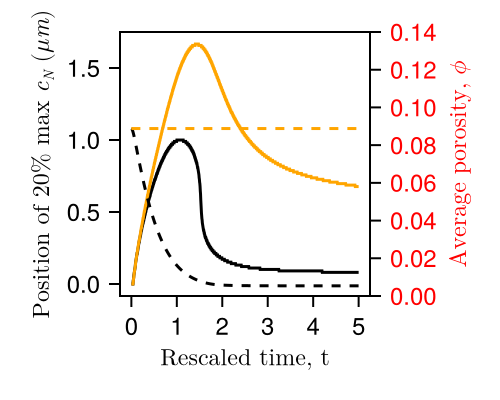

In [14]:
fig = Figure(size = (250,200), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false)
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

rs_wt_max = maximum(level_x_wt_rescaled)

lines!(ax,t_plot,level_x_wt_rescaled ./ rs_wt_max,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled ./ rs_wt_max,color = :orange,label = L"\text{Wnt11}")
# lines!(ax,t_plot,level_x_lm_rescaled,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# axislegend(ax,position = :lt)

ylims!(ax_por,0.,0.14)

ax.xticks = (0:1:5,string.(0:1:5))

save(plotsdir(exp_name * "/FinalFigures_DT/SMADPlots_NormalizedDistance.pdf"),fig)

fig


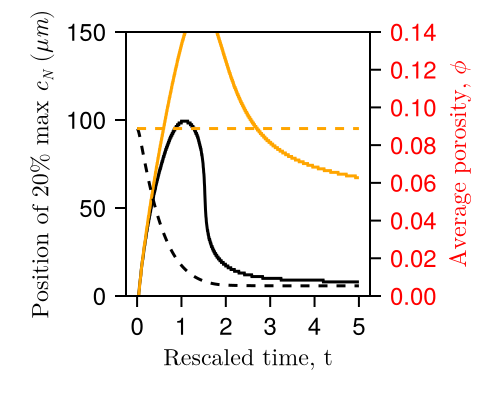

In [15]:
fig = Figure(size = (250,200), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false)
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

lines!(ax,t_plot,level_x_wt_rescaled ,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled ,color = :orange,label = L"\text{Wnt11}")
# lines!(ax,t_plot,level_x_lm_rescaled,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# axislegend(ax,position = :lt)

ylims!(ax_por,0.,0.14)

ylims!(ax,0,150)

ax.xticks = (0:1:5,string.(0:1:5))

save(plotsdir(exp_name * "/FinalFigures_DT/SMADPlots.pdf"),fig)

fig

In [16]:
smad_plot_df = DataFrames.DataFrame()

smad_plot_df[!,"Time"] = t_plot
smad_plot_df[!,"SMAD_curve_fits_WT_normalizedDistance"] = level_x_wt_rescaled ./ rs_wt_max
smad_plot_df[!,"SMAD_curve_fits_Wnt11_normalizedDistance"] = level_x_cp_rescaled ./ rs_wt_max
smad_plot_df[!,"SMAD_curve_fits_WT"] = level_x_wt_rescaled 
smad_plot_df[!,"SMAD_curve_fits_Wnt11"] = level_x_cp_rescaled 
smad_plot_df[!,"porosity_WT"] = porosity_dyn
smad_plot_df[!,"porosity_Wnt11"] = porosity_dyn_cp;

In [17]:
orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data,0.2)

(wt_t0 = 3938.280136591976, cp_t0 = 5119.764177569569, wt_xMax = 99.33110367892976, cp_xMax = 164.54849498327758, lm_xMax = 300.0, wt_d0 = 0.06060606060606061, cp_d0 = 0.21951219512195125, lm_d0 = 1.0, xmax_peak_ratio = 1.3000000000000003, xmax_mse = (0.824191870462677, 1.6118786902010498), xmax_mse_half = (0.824191870462677, 1.332296079667114), alpha_mse = 0.0009456152026607214, cp_lprod_t0 = 3630.7867925938035, wt_lprod_t0 = 2791.093430137256, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

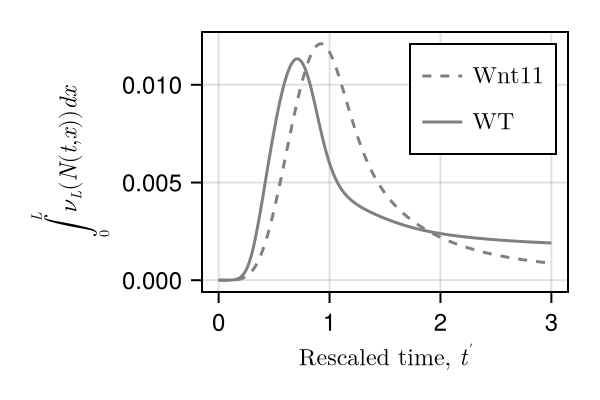

In [18]:
fig = Figure(size = (300,200), fontsize = 12.)

t_plot_int = LinRange(0,3*orig_metrics[:wt_t0],1000)

νN_int_cp,νN_int = get_integrated_lefty_prod_values(sol,sol_cp,t_plot_int,p_tuple,p_cp_tuple)

# nodal_prod_cp,nodal_prod = get_integrated_nodal_prod_values(sol,sol_cp,t_plot_int)

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, } t^{'}", ylabel= L"\int_0^L ν_L(N(t,x)) dx" )

lines!(ax,LinRange(0,3,1000),νN_int_cp,linestyle = :dash,color = :grey, label = L"\text{Wnt11}")
lines!(ax,LinRange(0,3,1000),νN_int,color = :grey, label = L"\text{WT}")

axislegend(ax,position = :rt)

save(plotsdir(exp_name * "/FinalFigures_DT/TotalLeftyProd.pdf"),fig)

fig


In [19]:
intl_plot_df = DataFrames.DataFrame()

intl_plot_df[!,"Time"] = LinRange(0,3,1000)
intl_plot_df[!,"total_lefty_prod_WT"] = νN_int
intl_plot_df[!,"total_lefty_prod_Wnt11"] = νN_int_cp;

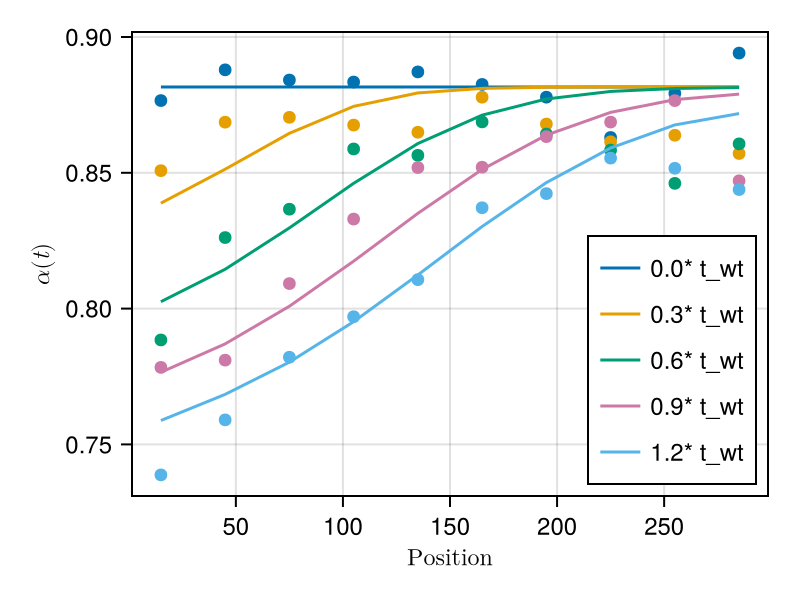

In [20]:
fig = Figure(size = (400,300), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)")

for (n,d) in enumerate(dyn_alpha[1:end-1])
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)

save(plotsdir(exp_name * "/FinalFigures_DT/AlphaFits.pdf"),fig)

fig


In [21]:
alpha_fits  = DataFrames.DataFrame()

alpha_fits[!,"Position (um)"] = alpha_x

for (n,d) in enumerate(dyn_alpha[1:end-1])
    alpha_fits[!,string(alpha_data_times_norm[n])* "* t_wt"] = d
end

alpha_fits

Row,Position (um),0.0* t_wt,0.3* t_wt,0.6* t_wt,0.9* t_wt,1.2* t_wt
,Int64,Float64,Float64,Float64,Float64,Float64
1,15,0.881586,0.838827,0.802551,0.776569,0.758804
2,45,0.881586,0.851315,0.814484,0.787008,0.768424
3,75,0.881586,0.864543,0.829708,0.800872,0.780291
4,105,0.881586,0.874456,0.846128,0.817459,0.795181
5,135,0.881586,0.879408,0.860773,0.835073,0.812403
6,165,0.881586,0.881079,0.871232,0.851248,0.830221
7,195,0.881586,0.881491,0.877186,0.863876,0.846393
8,225,0.881586,0.881571,0.879955,0.872247,0.859133
9,255,0.881586,0.881584,0.881041,0.876942,0.867624


In [22]:
# alpha_data_times_norm_v = [0.,0.3,0.6,0.9,1.2,1.5,1.8,2.1] .* 1.2

alpha_data_times_norm_v = [i for i in 0:0.25:5]

t_check = alpha_data_times_norm_v[2:end] .* orig_metrics[:wt_t0]

prob_finite = remake(prob,tspan = (0,alpha_data_times_norm_v[end] * orig_metrics[:wt_t0]))

sol_profiles = solve(prob_finite, p = p_tuple, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);
sol_profiles_cp = solve(prob_finite, p = p_cp_tuple, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);

dyn_N = [sol[1:150,1] for sol in sol_profiles.u[1:length(t_check)]]
dyn_L = [sol[1:150,2] for sol in sol_profiles.u[1:length(t_check)]];
dyn_α = [sol[1:150,4] for sol in sol_profiles.u[1:length(t_check)]];

bin_size = 10

dyn_N_binned = [[mean(N[n+1:n+bin_size]) for n in 0:bin_size:150-bin_size] for N in dyn_N]

dyn_N_cp = [sol[1:150,1] for sol in sol_profiles_cp.u[1:length(t_check)]];
dyn_L_cp = [sol[1:150,2] for sol in sol_profiles_cp.u[1:length(t_check)]];
dyn_α_cp = [sol[1:150,4] for sol in sol_profiles_cp.u[1:length(t_check)]];

N_max = maximum(vcat(maximum.(dyn_N),maximum.(dyn_N_cp)))
L_max = maximum(vcat(maximum.(dyn_N),maximum.(dyn_N_cp)))

dyn_N_cp_binned = [[mean(N[n+1:n+bin_size]) for n in 0:bin_size:150-bin_size] for N in dyn_N_cp]

lefty_prod_profiles_cp = [ν.(cN,σ.(p_cp_tuple[:σL0],ϕ0,ϕ.(α)),p_cp_tuple[:NL],p_cp_tuple[:mL]) for (cN,α) in zip(dyn_N_cp,dyn_α_cp)];
lefty_prod_profiles = [ν.(cN,σ.(p_tuple[:σL0],ϕ0,ϕ.(α)),p_tuple[:NL],p_tuple[:mL]) for (cN,α) in zip(dyn_N,dyn_α)];

nodal_prod_profiles_cp = [ν.(cN,σ.(p_cp_tuple[:σN0],ϕ0,ϕ.(α)),p_cp_tuple[:Na],p_cp_tuple[:mN]) for (cN,α) in zip(dyn_N_cp,dyn_α_cp)];
nodal_prod_profiles = [ν.(cN,σ.(p_tuple[:σN0],ϕ0,ϕ.(α)),p_tuple[:Na],p_tuple[:mN]) for (cN,α) in zip(dyn_N,dyn_α)];

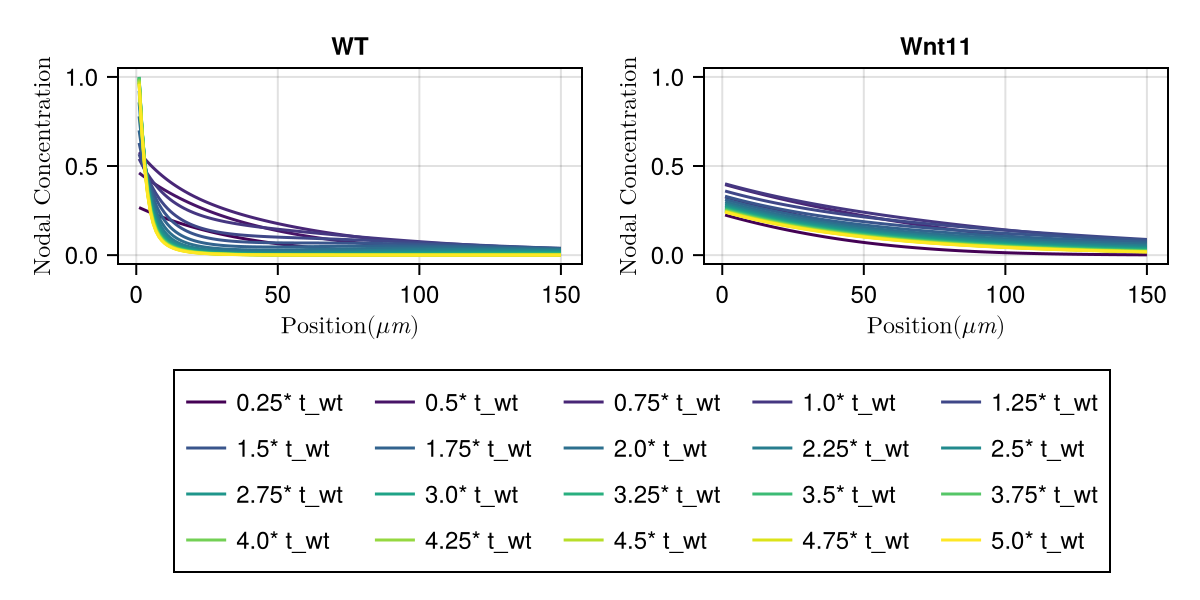

In [23]:
fig = Figure(size = (600,300), fontsize = 12.)

ax1 = Axis(fig[1,1], xlabel = L"\text{Position} ( \mu m)", ylabel= L"\text{Nodal Concentration}", title = "WT")

for (i,N) in enumerate(dyn_N)
    lines!(ax1,N ./ N_max,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

# axislegend(ax1,position = :rt)

ax2 = Axis(fig[1,2], xlabel = L"\text{Position} ( \mu m)", ylabel= L"\text{Nodal Concentration}", title = "Wnt11")

for (i,N) in enumerate(dyn_N_cp)
    lines!(ax2,N ./ N_max,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

linkyaxes!(ax1,ax2)

save(plotsdir(exp_name * "/FinalFigures_DT/NodalProfiles.pdf"),fig)

# axislegend(ax2,position = :rt)

Legend(fig[2,1:2],ax2,nbanks = 5)

fig

In [24]:
bin_x = [i for i in 0:bin_size:150-bin_size];

bin_x = bin_x .+ bin_size ./ 2;

In [25]:
nodal_profiles  = DataFrames.DataFrame()

nodal_profiles[!,"Position (um)"] = 1:1:150

for (i,N) in enumerate(dyn_N)
    nodal_profiles[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N ./  N_max
end

nodal_profiles_cp  = DataFrames.DataFrame()

nodal_profiles_cp[!,"Position (um)"] = 1:1:150

for (i,N) in enumerate(dyn_N_cp)
    nodal_profiles_cp[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N ./ N_max
end

In [26]:
N_binned_max = maximum(maximum.(dyn_N_binned))

288.9994591649544

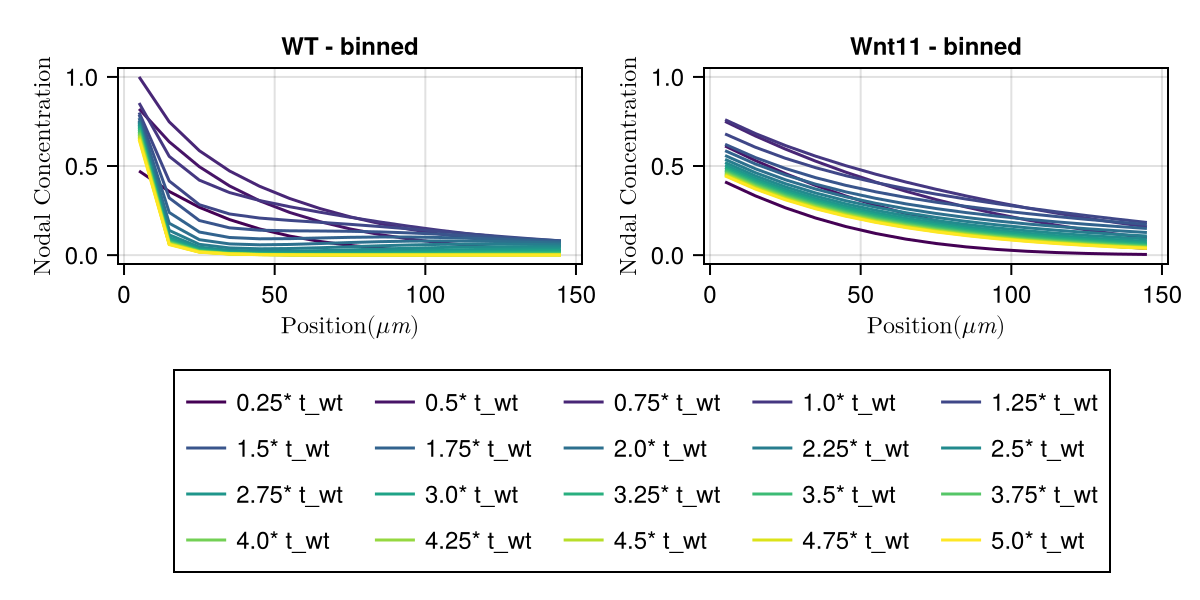

In [27]:
fig = Figure(size = (600,300), fontsize = 12.)

# fig = Figure(size = (1000,1000), fontsize = 12.)

ax1 = Axis(fig[1,1], xlabel = L"\text{Position} ( \mu m)", ylabel= L"\text{Nodal Concentration}", title = "WT - binned")

for (i,N) in enumerate(dyn_N_binned)
    lines!(ax1,bin_x,N ./ N_binned_max,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

ax2 = Axis(fig[1,2], xlabel = L"\text{Position} ( \mu m)", ylabel= L"\text{Nodal Concentration}", title = "Wnt11 - binned")

for (i,N) in enumerate(dyn_N_cp_binned)
    lines!(ax2,bin_x,N ./ N_binned_max,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

linkyaxes!(ax1,ax2)

Legend(fig[2,1:2],ax2,nbanks =  5)

save(plotsdir(exp_name * "/FinalFigures_DT/NodalProfilesBinned_10.pdf"),fig)

fig

In [28]:
nodal_profiles_binned10  = DataFrames.DataFrame()

nodal_profiles_binned10[!,"Position_bin10"] = bin_x

for (i,N) in enumerate(dyn_N_binned)
    nodal_profiles_binned10[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N ./ N_binned_max
end

nodal_profiles_binned10_cp  = DataFrames.DataFrame()

nodal_profiles_binned10_cp[!,"Position_bin10"] = bin_x

for (i,N) in enumerate(dyn_N_cp_binned)
    nodal_profiles_binned10_cp[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N ./ N_binned_max
end

In [29]:
bin_size = 5

dyn_N_binned = [[mean(N[n+1:n+bin_size]) for n in 0:bin_size:150-bin_size] for N in dyn_N]

dyn_N_cp = [sol[1:150,1] for sol in sol_profiles_cp.u[1:length(t_check)]];
dyn_L_cp = [sol[1:150,2] for sol in sol_profiles_cp.u[1:length(t_check)]];
dyn_α_cp = [sol[1:150,4] for sol in sol_profiles_cp.u[1:length(t_check)]];

dyn_N_cp_binned = [[mean(N[n+1:n+bin_size]) for n in 0:bin_size:150-bin_size] for N in dyn_N_cp]

lefty_prod_profiles_cp = [ν.(cN,σ.(p_cp_tuple[:σL0],ϕ0,ϕ.(α)),p_cp_tuple[:NL],p_cp_tuple[:mL]) for (cN,α) in zip(dyn_N_cp,dyn_α_cp)];
lefty_prod_profiles = [ν.(cN,σ.(p_tuple[:σL0],ϕ0,ϕ.(α)),p_tuple[:NL],p_tuple[:mL]) for (cN,α) in zip(dyn_N,dyn_α)];

nodal_prod_profiles_cp = [ν.(cN,σ.(p_cp_tuple[:σN0],ϕ0,ϕ.(α)),p_cp_tuple[:Na],p_cp_tuple[:mN]) for (cN,α) in zip(dyn_N_cp,dyn_α_cp)];
nodal_prod_profiles = [ν.(cN,σ.(p_tuple[:σN0],ϕ0,ϕ.(α)),p_tuple[:Na],p_tuple[:mN]) for (cN,α) in zip(dyn_N,dyn_α)];

In [30]:
N_binned_max = maximum(maximum.(dyn_N_binned))

334.7434578563164

In [31]:
bin_x = [i for i in 0:bin_size:150-bin_size];

bin_x = bin_x .+ bin_size ./ 2;

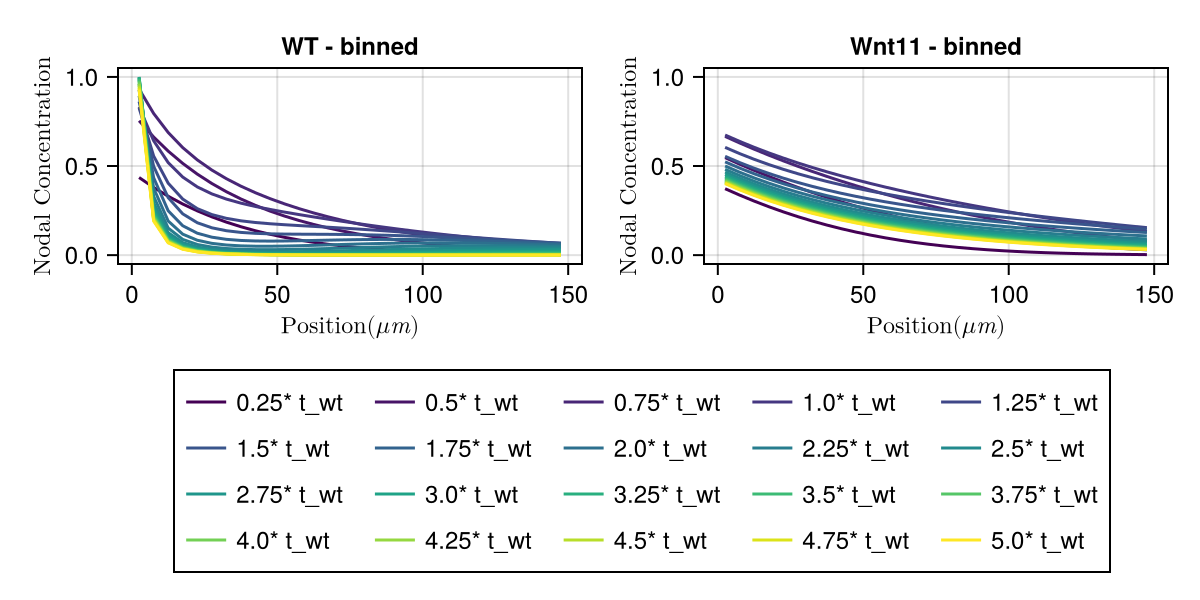

In [32]:
fig = Figure(size = (600,300), fontsize = 12.)

ax1 = Axis(fig[1,1], xlabel = L"\text{Position} ( \mu m)", ylabel= L"\text{Nodal Concentration}", title = "WT - binned")

for (i,N) in enumerate(dyn_N_binned)
    lines!(ax1,bin_x,N ./ N_binned_max,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

ax2 = Axis(fig[1,2], xlabel = L"\text{Position} ( \mu m)", ylabel= L"\text{Nodal Concentration}", title = "Wnt11 - binned")

for (i,N) in enumerate(dyn_N_cp_binned)
    lines!(ax2,bin_x,N ./ N_binned_max,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

linkyaxes!(ax1,ax2)

Legend(fig[2,1:2],ax2,nbanks =  5)

save(plotsdir(exp_name * "/FinalFigures_DT/NodalProfilesBinned_5.pdf"),fig)

fig

In [33]:
nodal_profiles_binned5  = DataFrames.DataFrame()

nodal_profiles_binned5[!,"Position_bin5"] = bin_x

for (i,N) in enumerate(dyn_N_binned)
    nodal_profiles_binned5[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N ./ N_binned_max
end

nodal_profiles_binned5_cp  = DataFrames.DataFrame()

nodal_profiles_binned5_cp[!,"Position_bin5"] = bin_x

for (i,N) in enumerate(dyn_N_cp_binned)
    nodal_profiles_binned5_cp[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N ./ N_binned_max
end

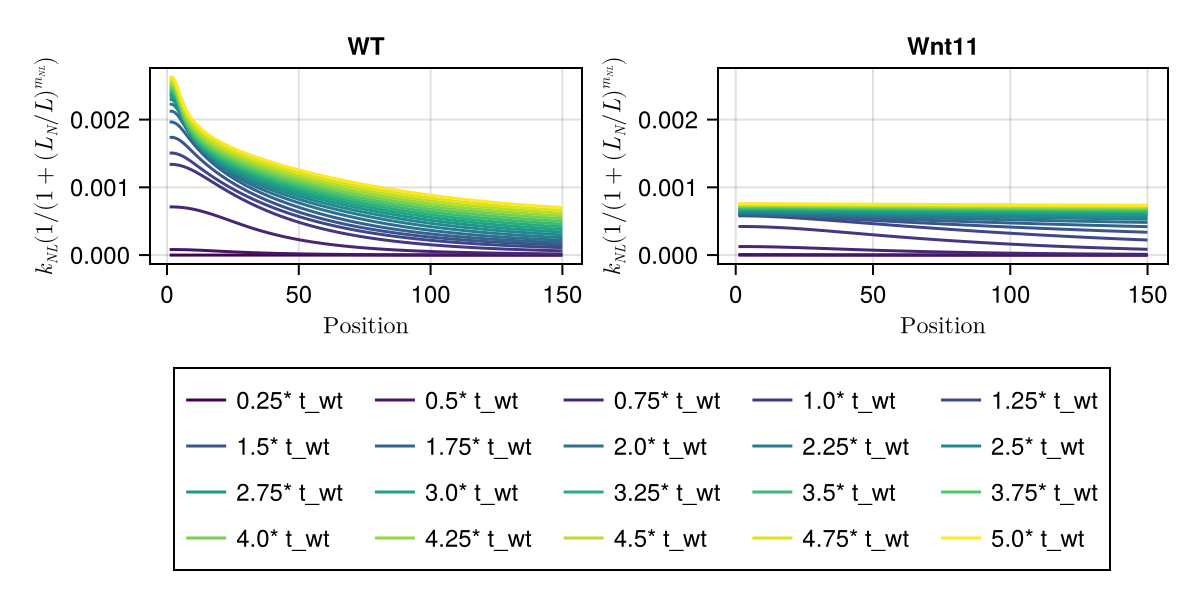

In [34]:
fig = Figure(size = (600,300), fontsize = 12.)

nodal_degr = [p_tuple[:kNL] .*(1 ./ (1 .+ (p_tuple[:LN] ./ L) .^ p_tuple[:mNL])) for L in dyn_L]
nodal_degr_cp = [p_cp_tuple[:kNL].*(1 ./ (1 .+ (p_cp_tuple[:LN] ./ L) .^ p_cp_tuple[:mNL])) for L in dyn_L_cp]

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"k_{NL} (1 / (1 + (L_N / L)^{m_{NL}})", title = "WT")

for (i,N) in enumerate(nodal_degr)
    lines!(ax1,N,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"k_{NL} (1 / (1 + (L_N / L)^{m_{NL}})", title = "Wnt11")

for (i,N) in enumerate(nodal_degr_cp)
    lines!(ax2,N,label = string(alpha_data_times_norm_v[2:end][i]) * "* t_wt",colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

Legend(fig[2,1:2],ax2,nbanks =  5)

linkyaxes!(ax1,ax2)

save(plotsdir(exp_name * "/FinalFigures_DT/LeftyInducedNodalDeg.pdf"),fig)

fig

In [35]:
nodal_deg_profiles  = DataFrames.DataFrame()

nodal_deg_profiles[!,"Position (um)"] = 1:1:150

for (i,N) in enumerate(nodal_degr)
    nodal_deg_profiles[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N
end

nodal_deg_profiles_cp  = DataFrames.DataFrame()

nodal_deg_profiles_cp[!,"Position (um)"] = 1:1:150

for (i,N) in enumerate(nodal_degr_cp)
    nodal_deg_profiles_cp[!,string(alpha_data_times_norm_v[2:end][i]) * "* t_wt"] = N
end

In [36]:
# XLSX.writetable(exp_name *  "FigureData" * ".xlsx", "SMADFits"=>smad_plot_df,"TotalLeftyProduction"=>intl_plot_df,"AlphaFits"=>alpha_fits,"AlphaExpData"=>alpha_data,"NodalProfiles_WT"=>nodal_profiles,"NodalProfiles_Wnt11"=>nodal_profiles_cp,"NodalProfiles_WT_binned"=>nodal_profiles_binned,"NodalProfiles_Wnt11_binned"=>nodal_profiles_cp_binned);

XLSX.writetable(plotsdir(exp_name *  "/FinalFigures_DT/FigureData" * ".xlsx"), "SMADFits"=>smad_plot_df,
"TotalLeftyProduction"=>intl_plot_df,"AlphaFits"=>alpha_fits,"AlphaExpData"=>alpha_data,
"NodalProfiles_WT"=>nodal_profiles,"NodalProfiles_Wnt11"=>nodal_profiles_cp,
"NodalProfiles_WT_binned10"=>nodal_profiles_binned10,"NodalProfiles_Wnt11_binned10"=>nodal_profiles_binned10_cp,
"NodalProfiles_WT_binned5"=>nodal_profiles_binned5,"NodalProfiles_Wnt11_binned5"=>nodal_profiles_binned5_cp,
"LftyInducedDeg_WT"=>nodal_deg_profiles,"LftyInducedDeg_Wnt11"=>nodal_deg_profiles_cp,"Parameters"=>parameter_df);

In [37]:
exp_name

"NodalLefty_DiffusionDominated_Zena_Set2"

In [38]:
parameter_df

Row,D_N0,D_L0,K_N0,K_L0,k_E,k_NL,σN0,σL0,N_a,N_L,N_E,L_N,s_0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.95,15.0,1.51949e-6,7.46531e-7,0.000259671,10.3034,0.01,0.000465389,31.6228,180.0,12.0,19.1507,5.0
